# Optimizing a mesh using a Differentiable Renderer

Differentiable rendering can be used to optimize the underlying 3D properties, like geometry and lighting, by backpropagating gradients from the loss in the image space. In this tutorial, we optimize geometry and texture of a single object based on a dataset of rendered ground truth views. This tutorial demonstrates functionality in `kaolin.render.mesh`, including the key `dibr_rasterization` function. See detailed [API documentation](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.mesh.html).

In addition, we demonstrate the use of [Kaolin's 3D checkpoints and training visualization](https://kaolin.readthedocs.io/en/latest/modules/kaolin.visualize.html) with the [Omniverse Kaolin App](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin/user_manual.html).

Before starting the tutorial please make sure that to have [examples/samples/rendered_clock.zip](examples/samples/rendered_clock.zip) uncompressed.

In [1]:
!pip install -q matplotlib

import json
import os
import glob
import time

from PIL import Image
import torch
import numpy as np
from matplotlib import pyplot as plt

import kaolin as kal

# path to the rendered image (using the data synthesizer)
rendered_path = "../samples/rendered_clock/"
# path to the output logs (readable with the training visualizer in the omniverse app)
logs_path = './logs/'

# We initialize the timelapse that will store USD for the visualization apps
timelapse = kal.visualize.Timelapse(logs_path) 

In [2]:
# Hyperparameters
num_epoch = 120 # 40
batch_size = 2
laplacian_weight = 0.1
flat_weight = 0.001
image_weight = 0.0 # 0.1
mask_weight = 1.
texture_lr = 5e-2
vertice_lr = 5e-4
scheduler_step_size = 20
scheduler_gamma = 0.5

texture_res = 400

# select camera angle for best visualization
test_batch_ids = [2, 5, 10]
test_batch_size = len(test_batch_ids)

# Generating Training Data

To optimize a mesh, typical training data includes RGB images and segmentation mask. One way to generate this data is to use the Data Generator in the [Omniverse Kaolin App](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin/user_manual.html#data-generator). We provide sample output of the app in `examples/samples/`.

## Parse synthetic data
We first need to parse the synthetic data generated by the omniverse app.
The omniverse app generate 1 file per type of data (which can be depth map, rgb image, segmentation map), and an additional metadata json file.

The json file contains two main fields:
- camera_properties: Contains all the data related to camera setting such as "clipping_range", "horizontal_aperture", "focal_length", "tf_mat"
- asset_transforms: Those are transformations that are applied by the [Omniverse Kaolin App](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin/user_manual.html#data-generator), such as rotation / translation between objects or normalization.

In [3]:
num_views = len(glob.glob(os.path.join(rendered_path,'*_rgb.png')))
train_data = []
for i in range(num_views):
    data = kal.io.render.import_synthetic_view(
        rendered_path, i, rgb=True, semantic=True)
    train_data.append(data)

dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, pin_memory=True) 

# Loading the Sphere Template

The optimization starts from deforming an input template mesh according to the input image. We will use a sphere template that provides better performance on objects without topological holes. We use "/kaolin/examples/samples/sphere.obj" for convenience.

In [4]:
# mesh = kal.io.obj.import_mesh('../samples/sphere.obj', with_materials=True)
mesh = kal.io.obj.import_mesh('../samples/bbox.obj', with_materials=True)
# the sphere is usually too small (this is fine-tuned for the clock)
vertices = mesh.vertices.cuda().unsqueeze(0) * 0.75
vertices.requires_grad = True
faces = mesh.faces.cuda()
uvs = mesh.uvs.cuda().unsqueeze(0)
face_uvs_idx = mesh.face_uvs_idx.cuda()


face_uvs = kal.ops.mesh.index_vertices_by_faces(uvs, face_uvs_idx).detach()
face_uvs.requires_grad = False

texture_map = torch.ones((1, 3, texture_res, texture_res), dtype=torch.float, device='cuda',
                         requires_grad=True)

# The topology of the mesh and the uvs are constant
# so we can initialize them on the first iteration only
timelapse.add_mesh_batch(
    iteration=0,
    category='optimized_mesh',
    faces_list=[mesh.faces.cpu()],
    uvs_list=[mesh.uvs.cpu()],
    face_uvs_idx_list=[mesh.face_uvs_idx.cpu()],
)

# Preparing the losses and regularizer

During training we will use different losses:
- an image loss: an L1 loss based on RGB image.
- a mask loss: an Intersection over Union (IoU) of the segmentation mask with the soft_mask output by DIB-R rasterizer.
- a laplacian loss: to avoid deformation that are too strong.
- a flat loss: to keep a smooth surface and avoid faces intersecting.

For that we need to compute the laplacian matrix and some adjacency information
(the face idx of faces connected to each edge)


In [5]:
## Separate vertices center as a learnable parameter
vertices_init = vertices.clone().detach()
vertices_init.requires_grad = False

# This is the center of the optimized mesh, separating it as a learnable parameter helps the optimization. 
vertice_shift = torch.zeros((3,), dtype=torch.float, device='cuda',
                            requires_grad=True)

def recenter_vertices(vertices, vertice_shift):
    """Recenter vertices on vertice_shift for better optimization"""
    vertices_min = vertices.min(dim=1, keepdim=True)[0]
    vertices_max = vertices.max(dim=1, keepdim=True)[0]
    vertices_mid = (vertices_min + vertices_max) / 2
    vertices = vertices - vertices_mid + vertice_shift
    return vertices


nb_faces = faces.shape[0]
nb_vertices = vertices_init.shape[1]
face_size = 3

## Set up auxiliary laplacian matrix for the laplacian loss
vertices_laplacian_matrix = kal.ops.mesh.uniform_laplacian(
    nb_vertices, faces) 

# Setting up optimizer

In [6]:
vertices_optim  = torch.optim.Adam(params=[vertices, vertice_shift],
                                   lr=vertice_lr)
texture_optim = torch.optim.Adam(params=[texture_map], lr=texture_lr)
vertices_scheduler = torch.optim.lr_scheduler.StepLR(
    vertices_optim,
    step_size=scheduler_step_size,
    gamma=scheduler_gamma)
texture_scheduler = torch.optim.lr_scheduler.StepLR(
    texture_optim,
    step_size=scheduler_step_size,
    gamma=scheduler_gamma)

# Training

This toy tutorial optimizes geometry and texture of the mesh directly to demonstrate losses, rasterization and 3D checkpoints available in Kaolin.

These components can be combined with a neural architecture of your choice to learn tasks like image to 3D mesh.

In [7]:
for epoch in range(num_epoch):
    for idx, data in enumerate(dataloader):
        vertices_optim.zero_grad()
        texture_optim.zero_grad()
        gt_image = data['rgb'].cuda()
        gt_mask = data['semantic'].cuda()
        cam_transform = data['metadata']['cam_transform'].cuda()
        cam_proj = data['metadata']['cam_proj'].cuda()
        
        ### Prepare mesh data with projection regarding to camera ###
        vertices_batch = recenter_vertices(vertices, vertice_shift)

        face_vertices_camera, face_vertices_image, face_normals = \
            kal.render.mesh.prepare_vertices(
                vertices_batch.repeat(batch_size, 1, 1),
                faces, cam_proj, camera_transform=cam_transform
            )

        ### Perform Rasterization ###
        # Construct attributes that DIB-R rasterizer will interpolate.
        # the first is the UVS associated to each face
        # the second will make a hard segmentation mask
        face_attributes = [
            face_uvs.repeat(batch_size, 1, 1, 1),
            torch.ones((batch_size, nb_faces, 3, 1), device='cuda')
        ]

        image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
            gt_image.shape[1], gt_image.shape[2], face_vertices_camera[:, :, :, -1],
            face_vertices_image, face_attributes, face_normals[:, :, -1])

        # image_features is a tuple in composed of the interpolated attributes of face_attributes
        texture_coords, mask = image_features
        image = kal.render.mesh.texture_mapping(texture_coords,
                                                texture_map.repeat(batch_size, 1, 1, 1), 
                                                mode='bilinear')
        image = torch.clamp(image * mask, 0., 1.)
        
        ### Compute Losses ###
        image_loss = torch.mean(torch.abs(image - gt_image))
        mask_loss = kal.metrics.render.mask_iou(soft_mask,
                                                gt_mask.squeeze(-1))
        # laplacian loss
        vertices_mov = vertices - vertices_init
        vertices_mov_laplacian = torch.matmul(vertices_laplacian_matrix, vertices_mov)
        laplacian_loss = torch.mean(vertices_mov_laplacian ** 2) * nb_vertices * 3

        loss = (
            image_loss * image_weight +
            mask_loss * mask_weight +
            laplacian_loss * laplacian_weight
        )
        ### Update the mesh ###
        loss.backward()
        vertices_optim.step()
        texture_optim.step()

    vertices_scheduler.step()
    texture_scheduler.step()
    print(f"Epoch {epoch} - loss: {float(loss)}")
    
    ### Write 3D Checkpoints ###
    pbr_material = [
        {'rgb': kal.io.materials.PBRMaterial(diffuse_texture=torch.clamp(texture_map[0], 0., 1.))}
    ]

    vertices_batch = recenter_vertices(vertices, vertice_shift)

    # We are now adding a new state of the mesh to the timelapse
    # we only modify the texture and the vertices position
    timelapse.add_mesh_batch(
        iteration=epoch,
        category='optimized_mesh',
        vertices_list=[vertices_batch[0]],
        materials_list=pbr_material
    ) 

Epoch 0 - loss: 0.8623601198196411
Epoch 1 - loss: 0.8711439371109009
Epoch 2 - loss: 0.8645376563072205
Epoch 3 - loss: 0.8126259446144104
Epoch 4 - loss: 0.8751068115234375
Epoch 5 - loss: 0.7593916058540344
Epoch 6 - loss: 0.815131664276123
Epoch 7 - loss: 0.7612875699996948
Epoch 8 - loss: 0.7255313396453857
Epoch 9 - loss: 0.6877281069755554
Epoch 10 - loss: 0.6137307286262512
Epoch 11 - loss: 0.6042091250419617
Epoch 12 - loss: 0.5947365760803223
Epoch 13 - loss: 0.5469186305999756
Epoch 14 - loss: 0.4522549510002136
Epoch 15 - loss: 0.27929720282554626
Epoch 16 - loss: 0.43813592195510864
Epoch 17 - loss: 0.19700753688812256
Epoch 18 - loss: 0.20533232390880585
Epoch 19 - loss: 0.17751558125019073
Epoch 20 - loss: 0.20557446777820587
Epoch 21 - loss: 0.24090546369552612
Epoch 22 - loss: 0.20946496725082397
Epoch 23 - loss: 0.1926754117012024
Epoch 24 - loss: 0.15133659541606903
Epoch 25 - loss: 0.16684117913246155
Epoch 26 - loss: 0.16746410727500916
Epoch 27 - loss: 0.193614527

# Visualize training

You can now use [the Omniverse app](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin) to visualize the mesh optimization over training by using the training visualizer on "./logs/", where we stored the checkpoints.

You can also show the rendered image generated by DIB-R and the learned texture map with your 2d images libraries.

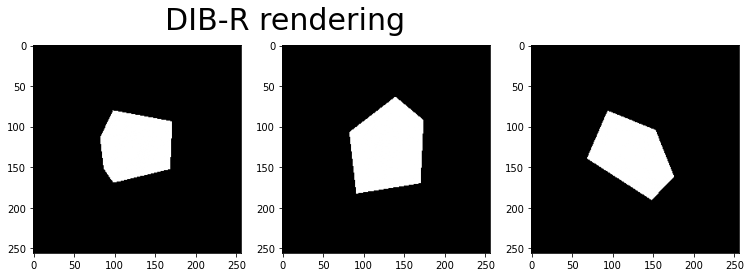

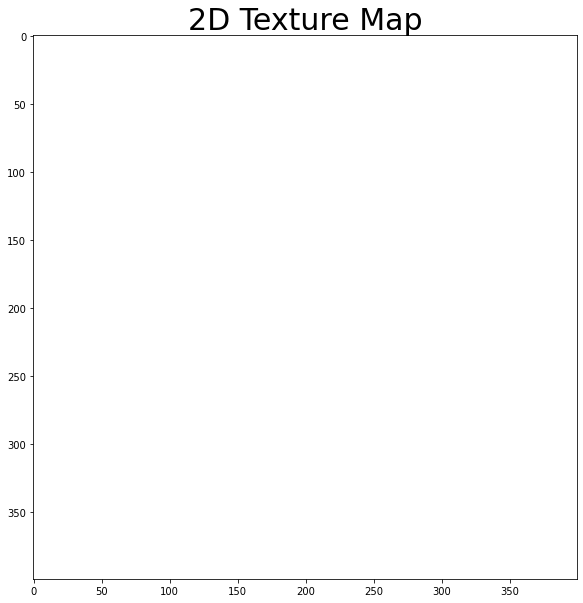

In [8]:
with torch.no_grad():
    # This is similar to a training iteration (without the loss part)
    data_batch = [train_data[idx] for idx in test_batch_ids]
    cam_transform = torch.stack([data['metadata']['cam_transform'] for data in data_batch], dim=0).cuda()
    cam_proj = torch.stack([data['metadata']['cam_proj'] for data in data_batch], dim=0).cuda()

    vertices_batch = recenter_vertices(vertices, vertice_shift)

    face_vertices_camera, face_vertices_image, face_normals = \
        kal.render.mesh.prepare_vertices(
            vertices_batch.repeat(test_batch_size, 1, 1),
            faces, cam_proj, camera_transform=cam_transform
        )
    face_attributes = [
        face_uvs.repeat(test_batch_size, 1, 1, 1),
        torch.ones((test_batch_size, nb_faces, 3, 1), device='cuda'),
    ]

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        256, 256, face_vertices_camera[:, :, :, -1],
        face_vertices_image, face_attributes, face_normals[:, :, -1])

    texture_coords, mask = image_features
    image = kal.render.mesh.texture_mapping(texture_coords,
                                            texture_map.repeat(test_batch_size, 1, 1, 1), 
                                            mode='bilinear')
    image = torch.clamp(image * mask, 0., 1.)
    
    ## Display the rendered images
    f, axarr = plt.subplots(1, test_batch_size, figsize=(7, 22))
    f.subplots_adjust(top=0.99, bottom=0.79, left=0., right=1.4)
    f.suptitle('DIB-R rendering', fontsize=30)
    for i in range(test_batch_size):
        axarr[i].imshow(image[i].cpu().detach())
        
## Display the texture
plt.figure(figsize=(10, 10))
plt.title('2D Texture Map', fontsize=30)
plt.imshow(torch.clamp(texture_map[0], 0., 1.).cpu().detach().permute(1, 2, 0))